# Introduction

This package provides functions to perform least-squares fits of quasinormal modes to ringdown waveforms. As long as you have a timeseries (either a single array or a dictionary of spherical-harmonic modes) you can use the functions provided by this package to perform fits.

In addition, some waveform classes are provided for convenience. These provide flux calculations and frame transformations which can be useful when doing ringdown analyses. Currently, there are three types of waveform class which the user can initialise:

 - **SXS**: Loads a waveform from the SXS catalog. This makes use of the `sxs` Python package to automatically download the simulation, so that you only need to specify the ID. 

 - **Surrogate**: Initializes a waveform generated by a surrogate. Currently implemented are **NRSur7dq4** and **NRHybSur3dq8**.

 - **Custom**: The user provides a dictionary of modes. 

The core fitting functions are all available in the `qnmfits.py` file. The waveform classes are in the `Waveforms` folder, and each inherit functions from `Waveforms/Base.BaseClass`.

# Analysing a SXS waveform

To demonstrate the features of the code we will work with the simulation SXS:BBH:0305, but everything will apply to a generic waveform.

## Class initialization

The only required argument for an SXS waveform is a simulation ID. However, it is a good idea to also change the zero-time to something more useful. Here we use the peak of the absolute value of the (2,2) mode (see the `Simulation` docstring for other options, including the ability to transform the modes with a rotation).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
qnmfits.download_cook_data()

#sims = []
#ids = [305, 1475, 1476, 1477, 1481, 1492, 1495, 1497, 1499, 1500, 1501, 1502, 1503, 1506, 1507, 1509]
#for id in ids:
#    sims.append(qnmfits.SXS(ID=id, zero_time=(2,2)))

sim = qnmfits.SXS(ID=305, zero_time=(2,2))

KerrQNM_08.h5 already downloaded.
KerrQNM_09.h5 already downloaded.
Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer


c:\qnmfits-main\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5


: 

In [ ]:
#sim.print_metadata()

In [ ]:
sim.times

array([-1804.13791279, -1803.5032643 , -1802.86745264, ...,
         151.47421942,   151.57421365,   151.67420788])

In [ ]:
# Time:
sim.times

# 22 mode
sim.h[2,2] # = hplus + i hcross

# Can you make a plot of 

array([ 1.15232258e-01-7.78880531e-04j,  1.15176171e-01-3.98142937e-03j,
        1.15030718e-01-7.18773693e-03j, ...,
       -6.71559606e-06-2.00978043e-05j, -6.84145863e-06-2.01459511e-05j,
       -6.96868187e-06-2.01867676e-05j])

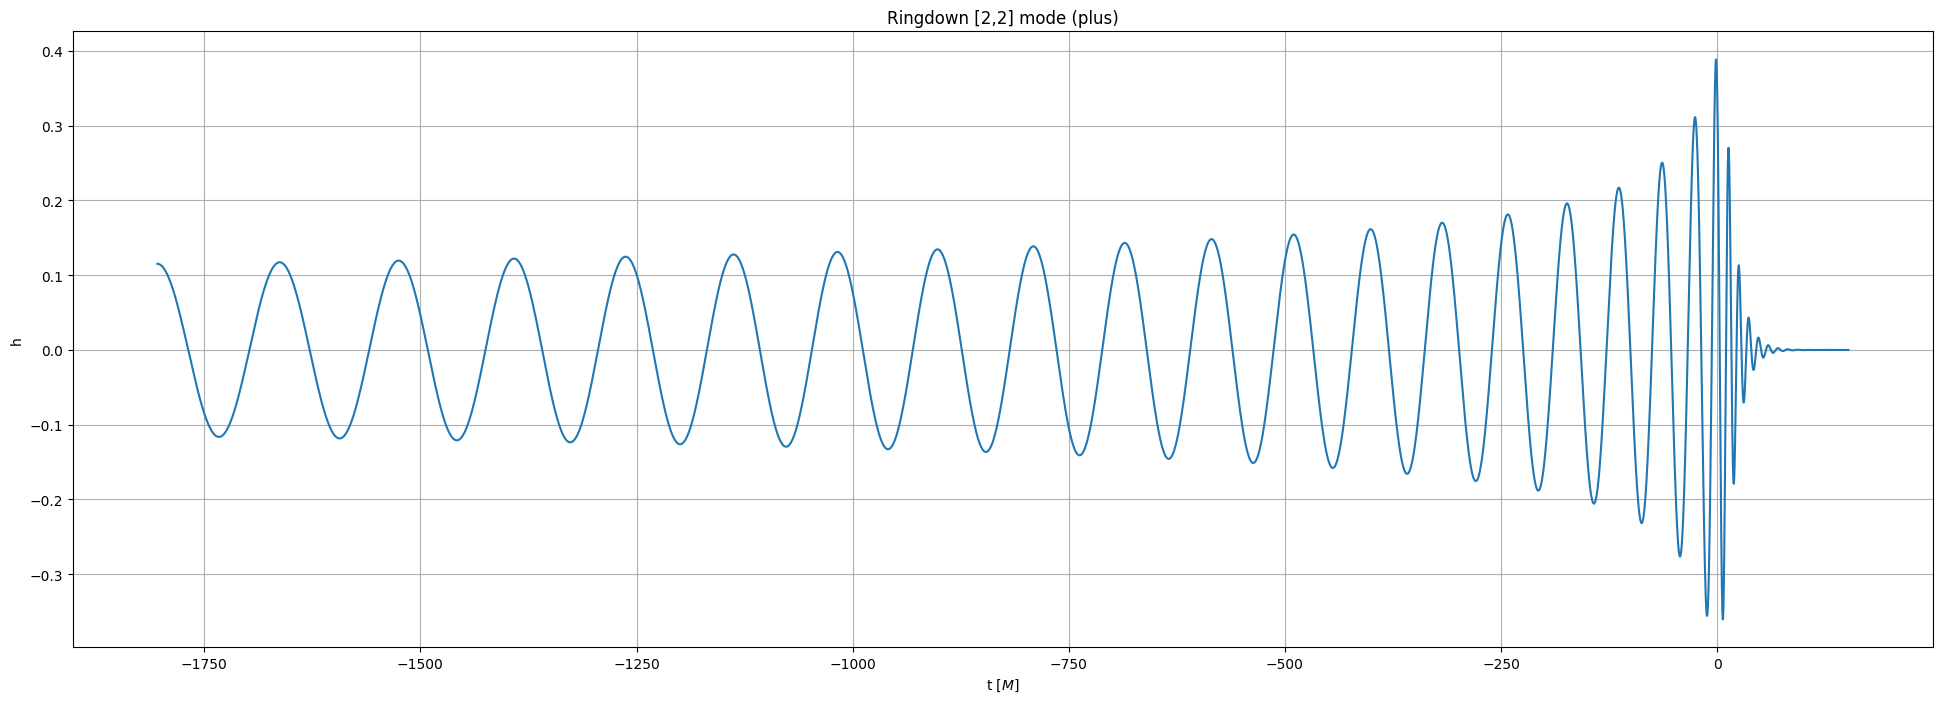

In [ ]:

fig, ax = plt.subplots(figsize=(24,8))
ax.plot(sim.times, np.real(sim.h[2,2]))
ax.grid(which='both')
ax.set_title(r'Ringdown [2,2] mode (plus)')
ax.set_xlabel(r't [$M$]')
ax.set_ylabel('h')
#ax.set_xlim(0,150)


plt.savefig('ringdownplus.png', dpi=500, bbox_inches='tight')


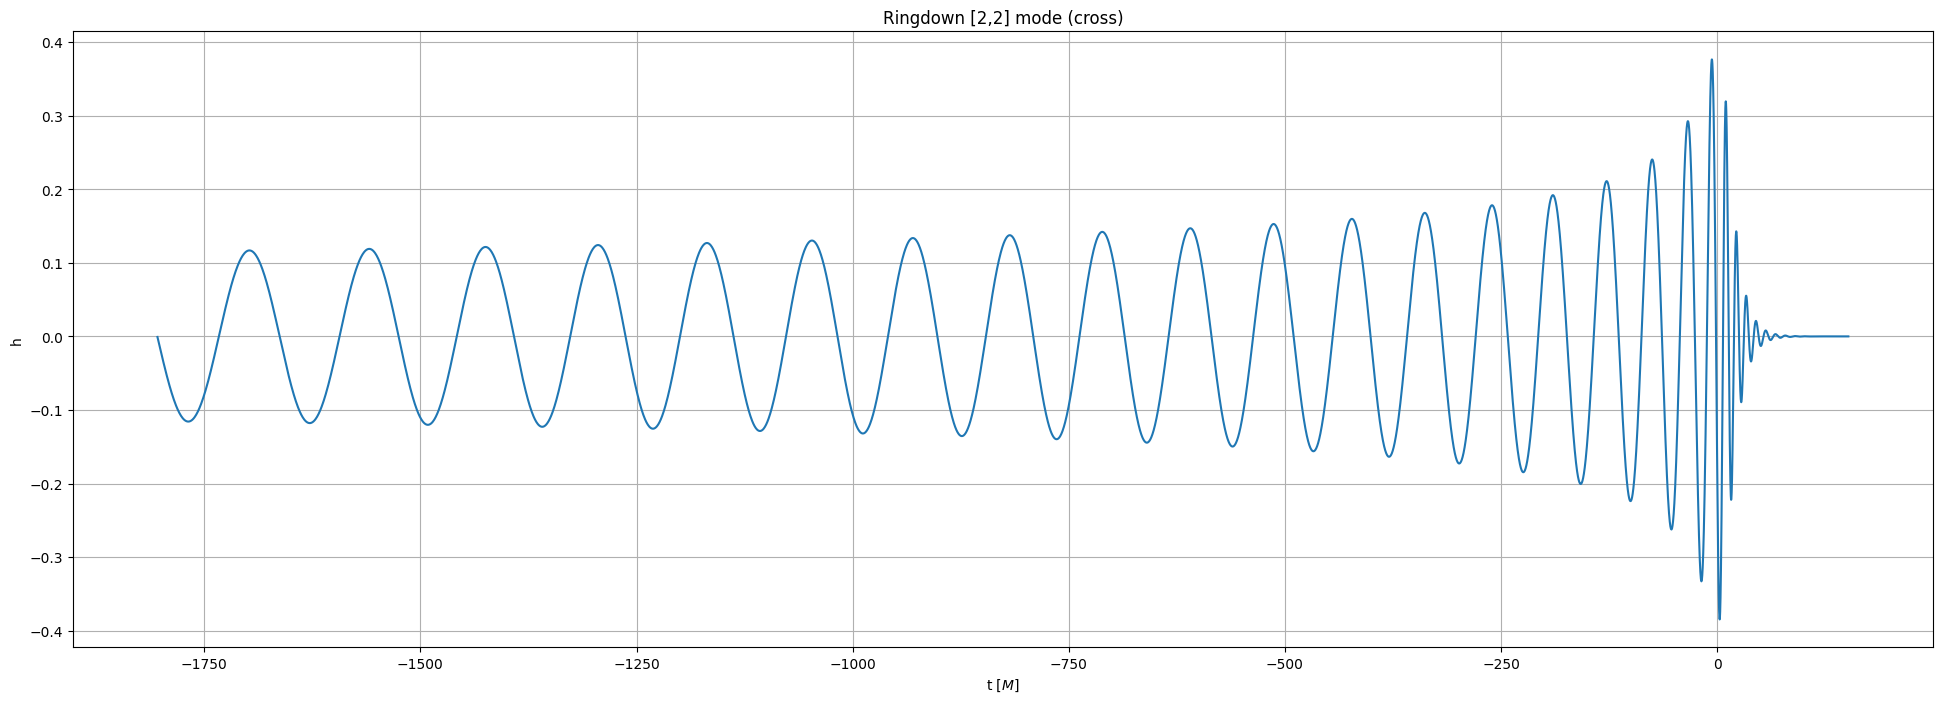

In [ ]:

fig, ax = plt.subplots(figsize=(24,8))
ax.plot(sim.times, np.imag(sim.h[2,2]))
ax.grid(which='both')
ax.set_title(r'Ringdown [2,2] mode (cross)')
ax.set_xlabel(r't [$M$]')
ax.set_ylabel('h')
#ax.set_xlim(0,150)

plt.savefig('ringdowncross.png', dpi=500, bbox_inches='tight')



Peak is at [0.0, 0.38950754530171744]


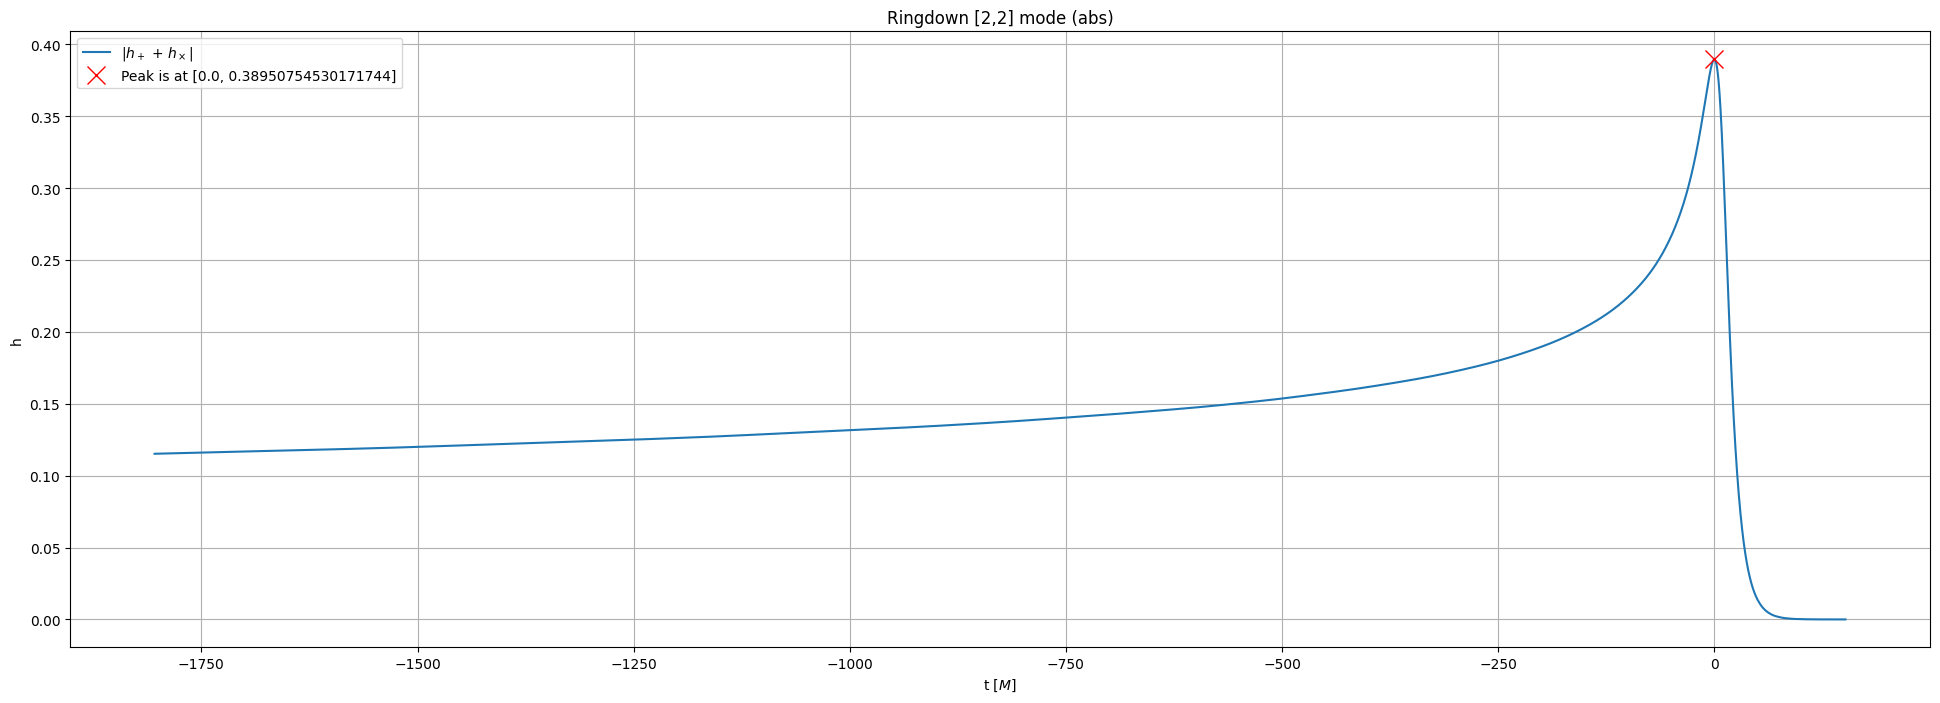

In [ ]:

fig, ax = plt.subplots(figsize=(24,8))
ax.plot(sim.times, np.abs(sim.h[2,2]), label = r"|$h_+$ + $h_\times$|")
ax.grid(which='both')
ax.set_title(r'Ringdown [2,2] mode (abs)')
ax.set_xlabel(r't [$M$]')
ax.set_ylabel('h')
#ax.set_xlim(0,150)


from scipy.signal import find_peaks

peak, _ = find_peaks(np.abs(sim.h[2,2]), height=0.35, prominence=0.2)
p = [sim.times[peak][0],np.abs(sim.h[2,2])[peak][0]]
ax.plot(sim.times[peak], np.abs(sim.h[2,2])[peak], "xr", markersize = 12.5, label = "Peak is at " + str(p))
print("Peak is at " + str(p))
ax.legend(loc='upper left')


plt.savefig('ringdownpeak.png', dpi=500, bbox_inches='tight')

Upon initialization various quantities get automatically calculated. This includes
 - Time derivatives of each mode (`sim.hdot`)
 - The evolving mass of the remnant black hole (`sim.Moft`), computed by integrating the energy flux backwards from the final remnant value
 - The evolving spin of the remnant black hole (`sim.chioft`), computed by integrating the angular momentum flux backwards from the final spin vector
 - The frequency evolution of each mode (`sim.foft`)
 
For SXS waveforms, we also get various derived metadata quantities such as the precession spin parameter, `sim.chip`, and the effective spin parameter `sim.chi_eff`.

## Perform a single QNM fit

In the `qnmfits` package there are functions for fitting to a single timeseries or to perform multimode fits to a dictionary of modes. We start with the simple single timeseries fit:

In [ ]:
qnmfits.ringdown_fit?

Signature:
qnmfits.ringdown_fit(
    times,
    data,
    modes,
    Mf,
    chif,
    t0,
    t0_method='geq',
    T=100,
)
Docstring:
Perform a least-squares fit to some data using a ringdown model.

Parameters
----------
times : array_like
    The times associated with the data to be fitted.
    
data : array_like
    The data to be fitted by the ringdown model.
    
modes : array_like
    A sequence of (l,m,n,sign) tuples to specify which QNMs to include in 
    the ringdown model. For regular (positive real part) modes use 
    sign=+1. For mirror (negative real part) modes use sign=-1. For 
    nonlinear modes, the tuple has the form 
    (l1,m1,n1,sign1,l2,m2,n2,sign2,...).
    
Mf : float
    The remnant black hole mass, which along with chif determines the QNM
    frequencies.
    
chif : float
    The magnitude of the remnant black hole spin.
    
t0 : float
    The start time of the ringdown model.
    
t0_method : str, optional
    A requested ringdown start time will in ge

In particular, note that the QNMs to fit are provided using tuples of length four: $(\ell, m, n, \pm)$. The fourth entry is either $+1$ or $-1$, and indicates the sign of the real part of the QNM frequency. In other words, $(\ell, m, n, +1)$ refers to the "regular" modes, and $(\ell, m, n, -1)$ referes to the "mirror" modes. This is different to the "prograde" and "retrograde" classification, mostly because I wanted to avoid any ambiguity regarding the $m=0$ modes.

C:\Users\willi\AppData\Local\Temp\ipykernel_22008\3322763842.py:13: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax1, [0.35,0.55,0.2,0.4])


[(2, 2, 0, 1), (2, 2, 1, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1), (2, 2, 6, 1), (2, 2, 7, 1)]


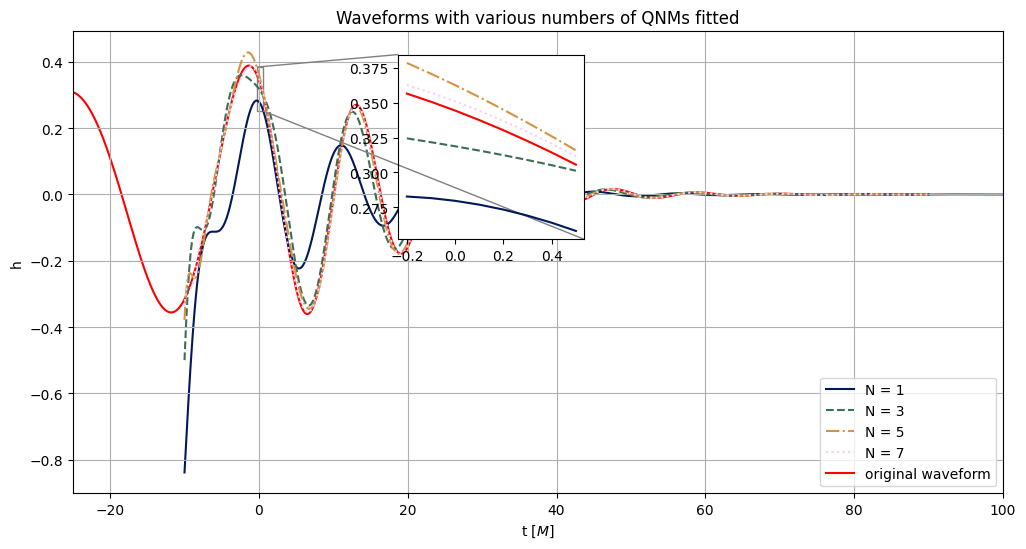

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition, mark_inset)
from cmcrameri import cm

fig, ax1 = plt.subplots(figsize=(12,6))

num = 10


# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.35,0.55,0.2,0.4])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines
# in grey linking the two axes.
mark_inset(ax1, ax2, loc1=2, loc2=4, fc="none", ec='0.5')

# get rid of bottom grey line




#inset width
max = 0.5
min = -0.25

nmodes = [1,3,5,7]
styles = ['-', '--', '-.', ':']
colors = cm.batlow(np.linspace(0,1,len(nmodes)))

for i, N in enumerate(nmodes):
    modes = [(2,2,n,1) for n in range(N+1)]
    print(modes)
    fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=-10
    )
    ax1.plot(fit['model_times'], np.real(fit['model']), label = f"N = {N}", linestyle = styles[i], color = colors[i], zorder=N)
    ax2.plot(fit['model_times'][(fit['model_times']<=max) & (fit['model_times']>=min)], np.real(fit['model'])[(fit['model_times']<=max) & (fit['model_times']>=min)], color = colors[i], linestyle = styles[i],label = str(N) + " modes",zorder=N)


ax1.plot(sim.times, np.real(sim.h[2,2]), label="original waveform", color="red",zorder=0)
ax1.grid(which='both')
ax1.set_title(r'Waveforms with various numbers of QNMs fitted')
ax1.set_xlabel(r't [$M$]')
ax1.set_ylabel('h')
ax1.legend(loc='lower right')
ax1.set_xlim(-25,100)
 
ax2.plot(sim.times[(sim.times<=max) & (sim.times>=min)], np.real(sim.h[2,2])[(sim.times<=max) & (sim.times>=min)], label="original waveform", color="red",zorder=0)

#plt.savefig('waveqnmfit.png', dpi=500, bbox_inches='tight')

In [ ]:
fit1 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    [(2,2,n,1) for n in range(1+1)],
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)
ax1.plot(fit1['model_times'], np.real(fit1['model']), label = f"N = {N}", color = colors[i], zorder=N)

fit2 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    [(2,2,n,1) for n in range(1+1)],
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)
ax1.plot(fit2['model_times'], abs(np.real(fit2['model'])-np.real(fit1['model'])), label = f"N = {N}", color = colors[i], zorder=N)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

[(2, 2, 0, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1), (2, 2, 6, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1), (2, 2, 6, 1), (2, 2, 7, 1)]
[(2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 2, 1), (2, 2, 3, 1), (2, 2, 4, 1), (2, 2, 5, 1), (2, 2, 6, 1), (2, 2, 7, 1), (2, 2, 8, 1)]
[0.33040382973729016, 0.3196121020537446, 0.17759864460485242, 0.24812499685246037, 0.22295908596757696, 0.23060732758696645, 0.22876767375537854, 0.22893413593088852, 0.2291203109596096]


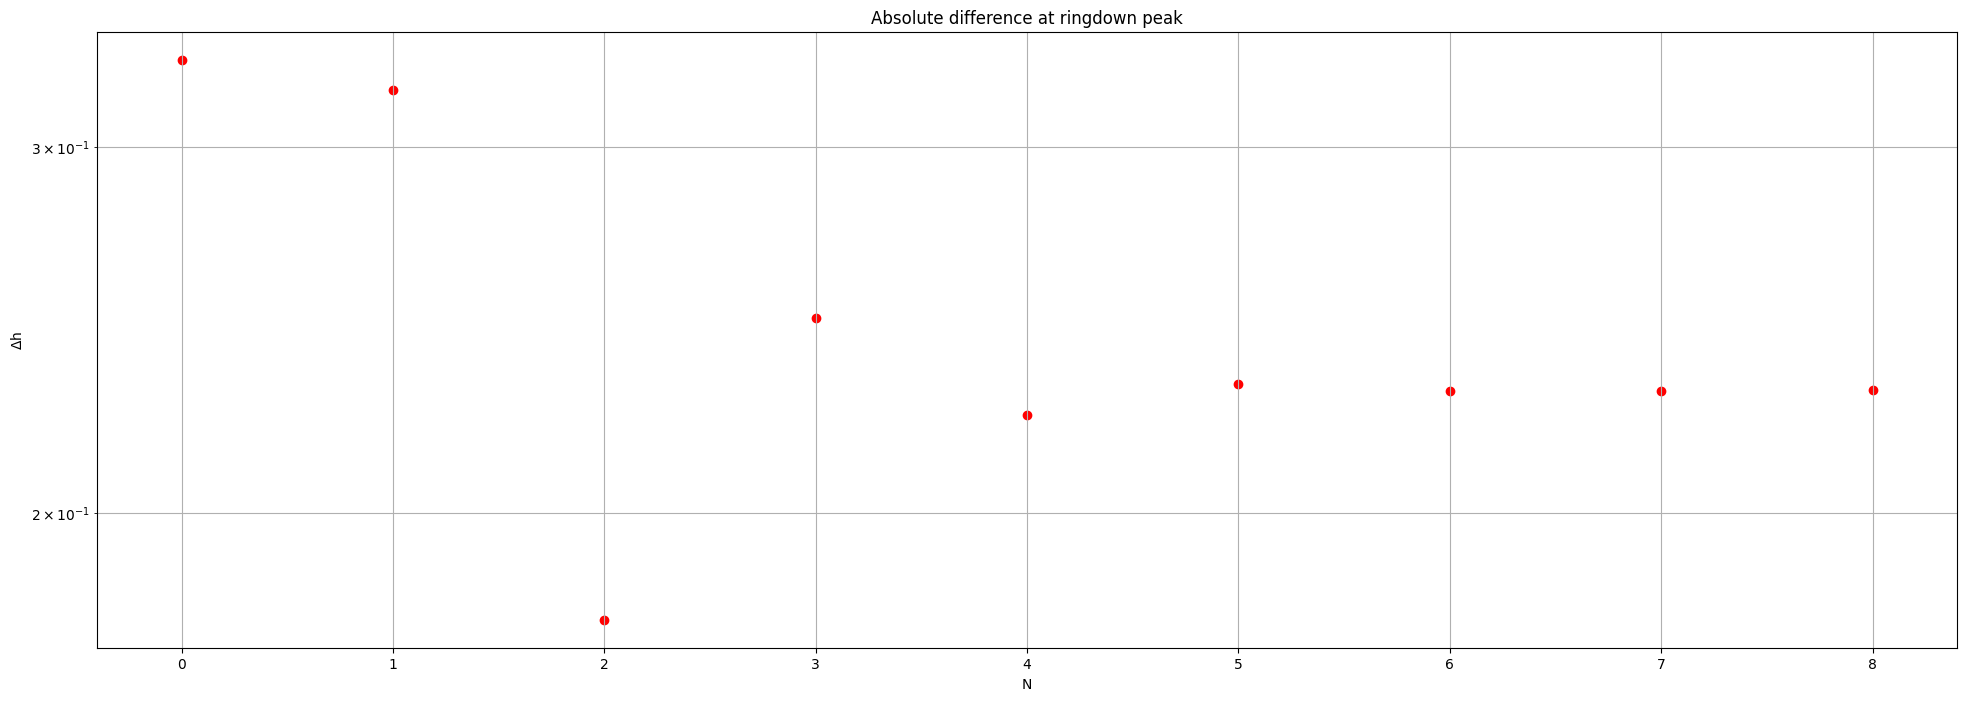

In [ ]:
fig, ax1 = plt.subplots(figsize=(24,8))


colors = cm.batlow(np.linspace(0,1,9))

dh = []

for N in range(1,10):
    modes = [(2,2,n,1) for n in range(N)]
    print(modes)
    fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0=0
    )
    diff = abs(np.real(fit['model'])[0]-np.real(sim.h[2,2])[0])
    dh.append(diff)
    #ax1.plot(fit['model_times'], np.real(fit['model']), label = f"N = {N}", color = colors[i], zorder=N)
    
print(dh)


ax1.scatter(range(0,9), dh, label="original waveform", color="red",zorder=0)
ax1.grid(which='both')
ax1.set_title(r'Absolute difference at ringdown peak')
ax1.set_xlabel(r'N')
ax1.set_ylabel(r'$\Delta$h')
#ax1.legend(loc='lower right')
#ax1.set_xlim(-25,150)
ax1.set_yscale('log')
#ax2.legend(loc=1)
#ax2.set_ylim(0.32,0.38)

# Some ad hoc tweaks.
#ax1.set_ylim(0,26)
#ax2.set_yticks(np.arange(0,2,0.4))
#ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
#ax2.tick_params(axis='x', which='major', pad=8)

plt.savefig('fitstartdiff.png', dpi=500, bbox_inches='tight')

(-1.0, 1.0)

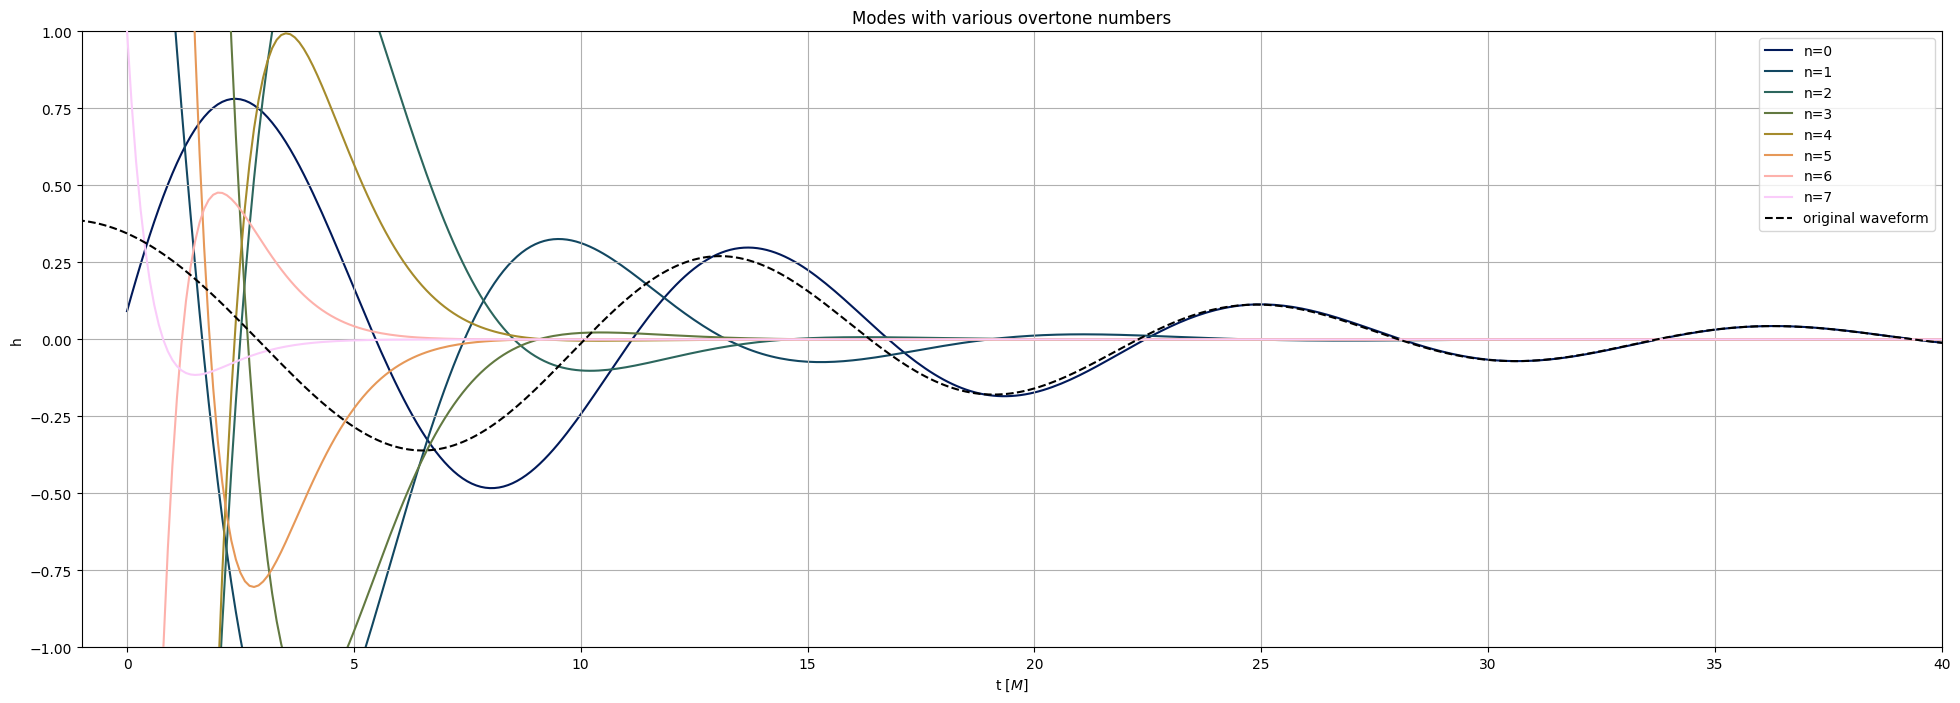

In [ ]:
fig, ax = plt.subplots(figsize=(24,8))

k = 8

colors = cm.batlow(np.linspace(0,1,k))


modes = [(2,2,n,1) for n in range(k)]
fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

#ax.plot(fit['model_times'], np.real(fit['model']), label =  "n="+ str(i), color=((1-(i/(num*1.25)+0.1)), 0, (i/(num*1.25)+0.15)),zorder=i)


for i in range(k):
    ax.plot(fit['model_times'], np.real(fit['C'][i]*np.exp(-1j*fit['frequencies'][i]*fit['model_times'])), alpha = 1,
            label =  "n="+ str(i), color=colors[i],zorder=i)
 

ax.plot(sim.times, np.real(sim.h[2,2]), label="original waveform", linestyle='dashed', color="black",zorder=100)
ax.grid(which='both')
ax.set_title(r'Modes with various overtone numbers')
ax.set_xlabel(r't [$M$]')
ax.set_ylabel('h')
ax.legend(loc='upper right')

ax.set_xlim(-1,40)
ax.set_ylim(-1,1)


#plt.savefig('waveqnmovertones.png', dpi=500, bbox_inches='tight')

[ 9.33623595e-02+9.64804009e-01j  3.12368221e+00-2.64611448e+00j
 -6.73776121e+00+3.07769590e+00j -2.44306850e+01+1.01108695e+01j
  2.00395356e+02-1.99843321e+02j -4.81789857e+02+9.50888682e+02j
  6.69398754e+02-2.33143808e+03j -6.76229091e+02+3.67697596e+03j
  4.98834708e+02-3.91470714e+03j -2.39383378e+02+2.69203451e+03j
  6.36961682e+01-1.07375004e+03j -6.62698919e+00+1.88150031e+02j]
Mismatch = 2.137570555005297e-07


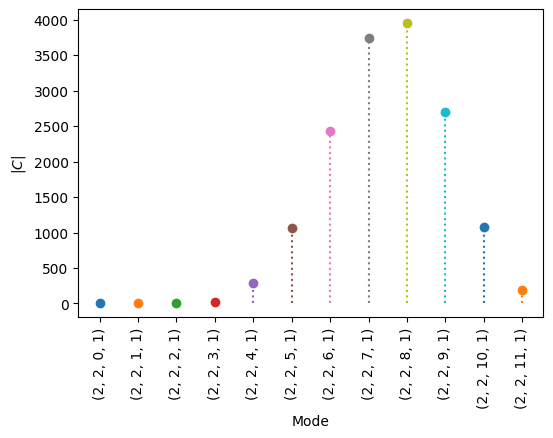

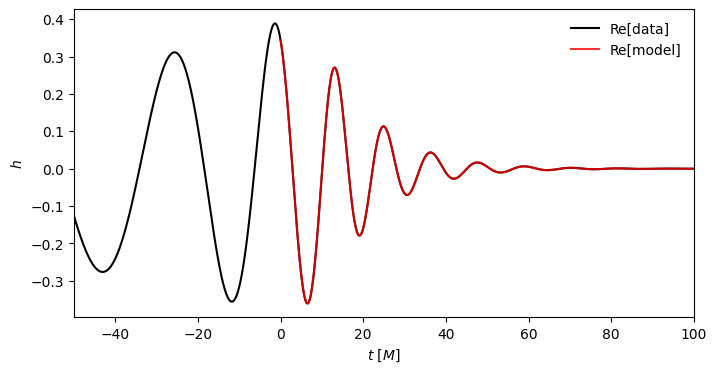

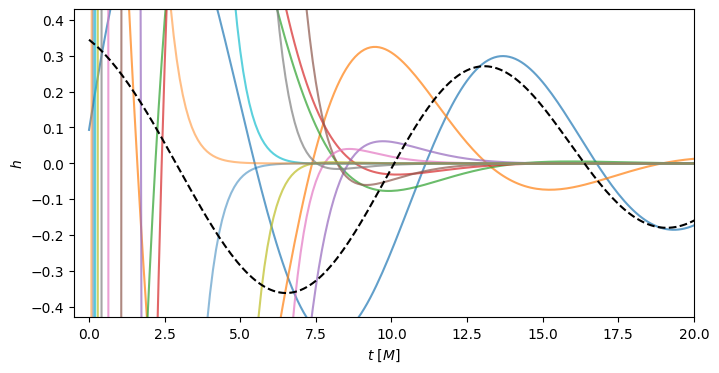

In [ ]:
# Perform a fit to the (2,2) spherical-harmonic mode using a ringdown model 
# with overtones of the fundamental (2,2,0) mode (up to and including n=7)

modes = [(2,2,n,1) for n in range(11+1)]

best_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)
print((best_fit['C']))
print(f"Mismatch = {best_fit['mismatch']}")

# Some plotting functions are provided for convenience:

qnmfits.plot_mode_amplitudes(
    best_fit['C'], best_fit['mode_labels'], log=False)

qnmfits.plot_ringdown(
    sim.times,
    sim.h[2,2],
    best_fit=best_fit
)

peak_value = np.max(abs(sim.h[2,2]))

qnmfits.plot_ringdown_modes(
    best_fit,
    xlim=(-0.5,20), 
    ylim=(-peak_value*1.1,peak_value*1.1), 
    legend=False)

## Perform fits for a range of ringdown start times

We can easily loop over a range of ringdown start times with the `qnmfits.mismatch_t0_array` function:

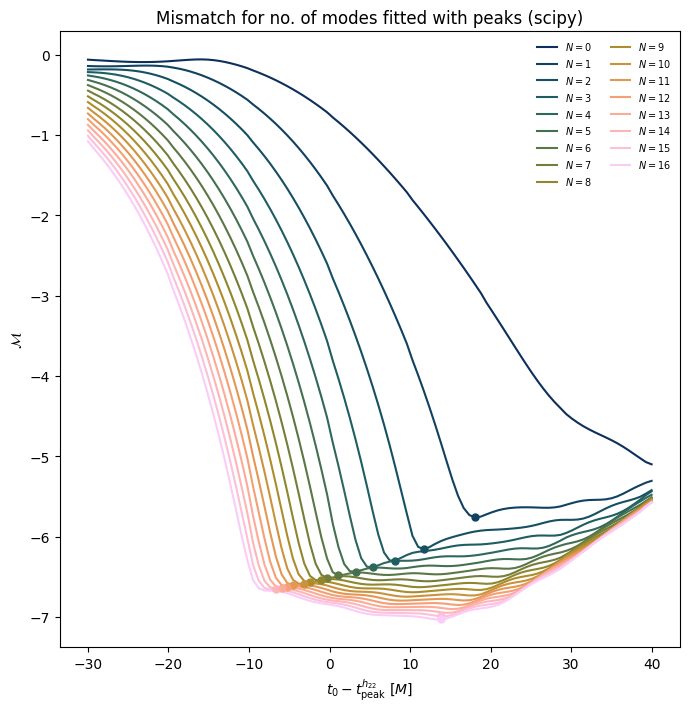

In [ ]:
from kneed import KneeLocator
from scipy.signal import find_peaks

fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 100)


N = 18
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(1,N):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log(Ms)/np.log(10)
    
    ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
    
    peak, _ = find_peaks(-logMs, height=3, prominence=1e-10)
    #print(peak)

    p = [t0s[peak],logMs[peak]]
    if len(peak) >= 1:
        ax.plot(t0s[peak[0]], logMs[peak[0]], "o", markersize = 5, color = colors[k], zorder=100)
        ptims.append(t0s[peak[0]])
        pMs.append(logMs[peak[0]])
    #print("Peak is at " + str(p))


#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (scipy)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
ax.legend(loc='lower right')
#ax.set_yscale('log')

#ax.set_xlim(-3,0)
#ax.set_ylim(-7,-6)


_ = ax.legend(ncol=2, frameon=False, fontsize=7)
#plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')

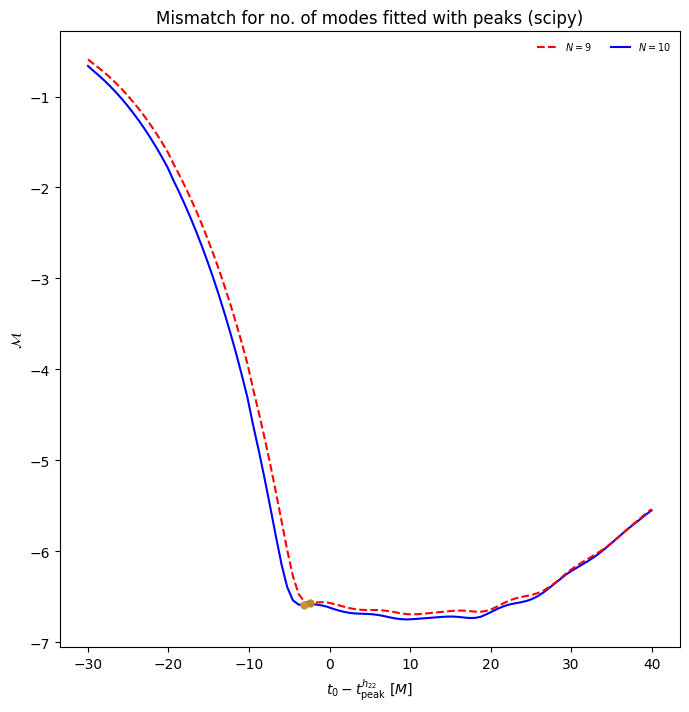

In [ ]:
from kneed import KneeLocator
from scipy.signal import find_peaks

fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 100)


N = 18
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(10,12,1):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log(Ms)/np.log(10)
    
    if k == 10:
        ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = "red",zorder=10, linestyle = '--')
    
    if k == 11:
        ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = "blue",zorder=1, linestyle = '-')

    peak, _ = find_peaks(-logMs, height=3, prominence=1e-10)
    #print(peak)

    p = [t0s[peak],logMs[peak]]
    if len(peak) >= 1:
        ax.plot(t0s[peak[0]], logMs[peak[0]], "o", markersize = 5, color = colors[k], zorder=100)
        ptims.append(t0s[peak[0]])
        pMs.append(logMs[peak[0]])
    #print("Peak is at " + str(p))


#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (scipy)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
ax.legend(loc='lower right')
#ax.set_yscale('log')

#ax.set_xlim(-3,0)
#ax.set_ylim(-7,-6)


_ = ax.legend(ncol=2, frameon=False, fontsize=7)
plt.savefig('mismatchpeaks910.png', dpi=500, bbox_inches='tight')

ValueError: x and y must be the same size

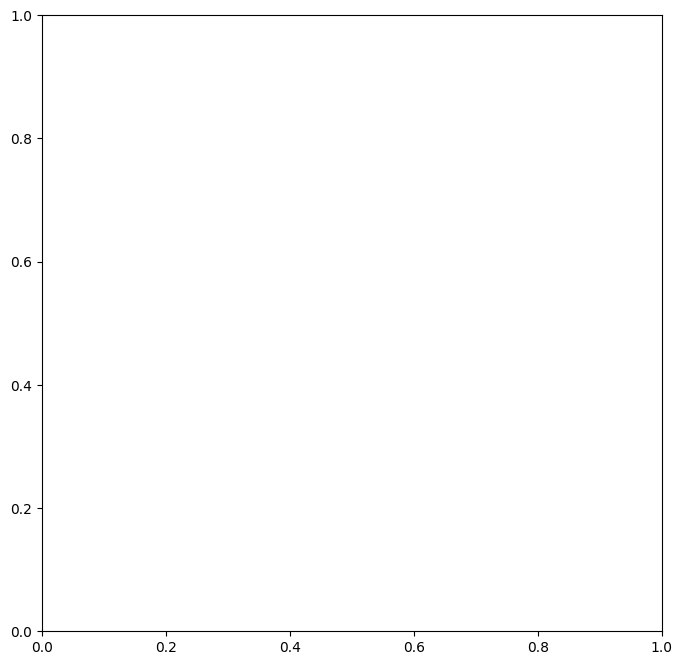

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(np.linspace(1,N-2,N-2),ptims,color="red")

#ax.grid(which='both')
ax.set_title(r'Start time vs no. of peaks fitted (scipy)')
ax.set_xlabel('$N$')
ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
#ax.set_yscale('log')

ax.set_yticks(np.linspace(-5,20,6))
ax.set_xticks(np.linspace(1,N-2,N-2))

#plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')

C:\Users\willi\AppData\Local\Temp\ipykernel_26128\2592550784.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "xr" (-> color='r'). The keyword argument will take precedence.
  ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "xr", markersize = 12.5, color = colors[k])


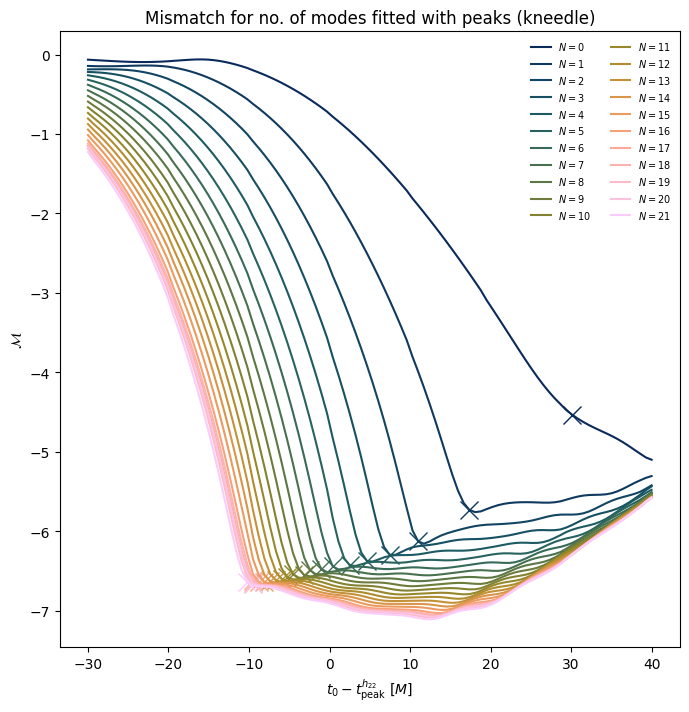

In [ ]:
from kneed import KneeLocator
from scipy.signal import find_peaks

fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 100)


N = 23
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(1,N):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log(Ms)/np.log(10)
    
    ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
    
    kneedle = KneeLocator(t0s, -logMs, S=0.01, curve="concave", direction="increasing", online = "true")
    ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "x", markersize = 12.5, color = colors[k])
    #print((kneedle.knee))
    #print((kneedle.elbow))
    pMs.append(logMs[np.ndarray.tolist(t0s).index(kneedle.knee)])
    ptims.append(kneedle.knee)


#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (kneedle)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
ax.legend(loc='lower right')
#ax.set_yscale('log')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)
#plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')

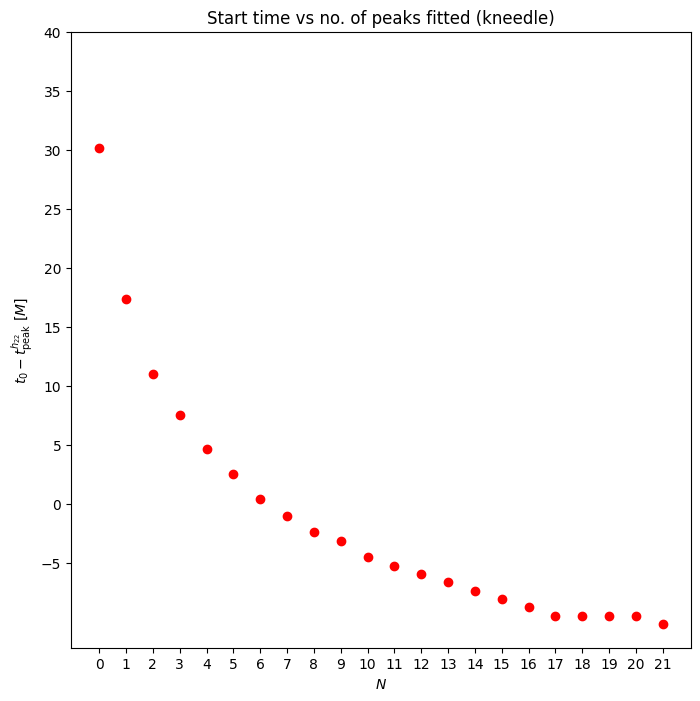

: 

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(np.arange(N-1),ptims,color="red")

#ax.grid(which='both')
ax.set_title(r'Start time vs no. of peaks fitted (kneedle)')
ax.set_xlabel('$N$')
ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
#ax.set_yscale('log')

ax.set_yticks(np.linspace(-5,40,10))
ax.set_xticks(np.arange(N-1))

#plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')

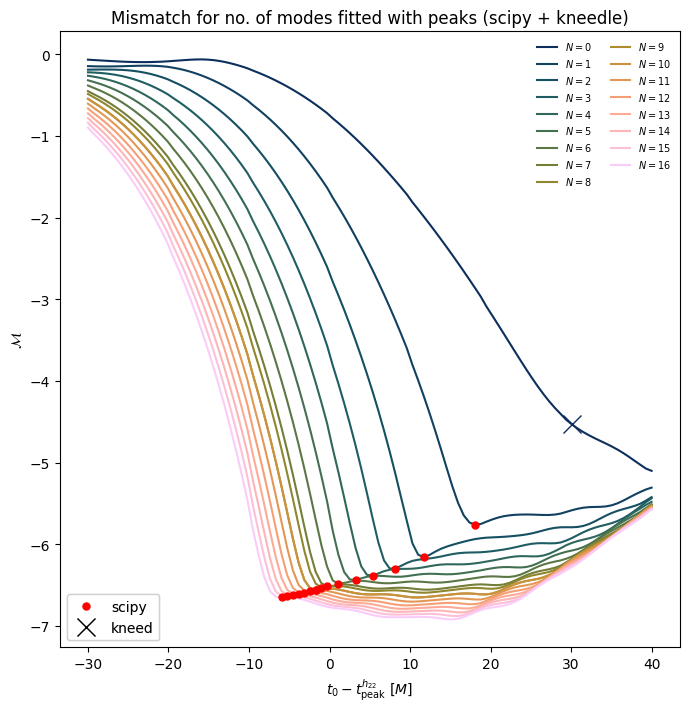

In [ ]:
from kneed import KneeLocator
from scipy.signal import find_peaks
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(8,8))


# The start times to use
t0s = np.linspace(-30, 40, 100)


N = 18
colors = cm.batlow(np.linspace(0,1,N))

pMs = []
ptims = []

for k in range(1,N):
    Ms = []
    modes = [(2,2,n,1) for n in range(k)]
    for i in range(len(t0s)):
        fit = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0s[i]
        )
        Ms.append(fit['mismatch'])

    logMs = np.log(Ms)/np.log(10)
    
    ax.plot(t0s, logMs, alpha = 1, label=f'$N = {modes[-1][-2]}$', color = colors[k],zorder=i)
    
    peak, _ = find_peaks(-logMs, height=3, prominence=0.0000000000000000001)
    #print(peak)

    p = [t0s[peak],logMs[peak]]

    if len(peak) >= 1:
        ax.plot(t0s[peak[0]], logMs[peak[0]], "o", markersize = 5, color = "red", zorder=100)
        ptims.append(t0s[peak[0]])
        pMs.append(logMs[peak[0]])
    else:
        kneedle = KneeLocator(t0s, -logMs, S=0.01, curve="concave", direction="increasing", online = "true")
        ax.plot(kneedle.knee, logMs[np.ndarray.tolist(t0s).index(kneedle.knee)], "x", markersize = 12.5, color = colors[k], zorder=100)
        pMs.append(logMs[np.ndarray.tolist(t0s).index(kneedle.knee)])
        ptims.append(kneedle.knee)



#ax.grid(which='both')
ax.set_title(r'Mismatch for no. of modes fitted with peaks (scipy + kneedle)')
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')
#ax.set_yscale('log')

legend1 = ax.legend(ncol=2, frameon=False, fontsize=7, loc='upper right')

# Add the first legend to the axis
ax.add_artist(legend1)

legend_elements = [Line2D([0], [0], marker='o', color='red', label='scipy',
                          markerfacecolor='red', markersize=5, linestyle='None'),
                   Line2D([0], [0], marker='x', color='black', label='kneed',
                          markerfacecolor='black', markersize=12.5, linestyle='None')]

# Create the first legend
legend2 = ax.legend(handles=legend_elements, loc='lower left')

# Add the first legend to the axis
ax.add_artist(legend2)


plt.savefig('mismatchpeaks.png', dpi=500, bbox_inches='tight')

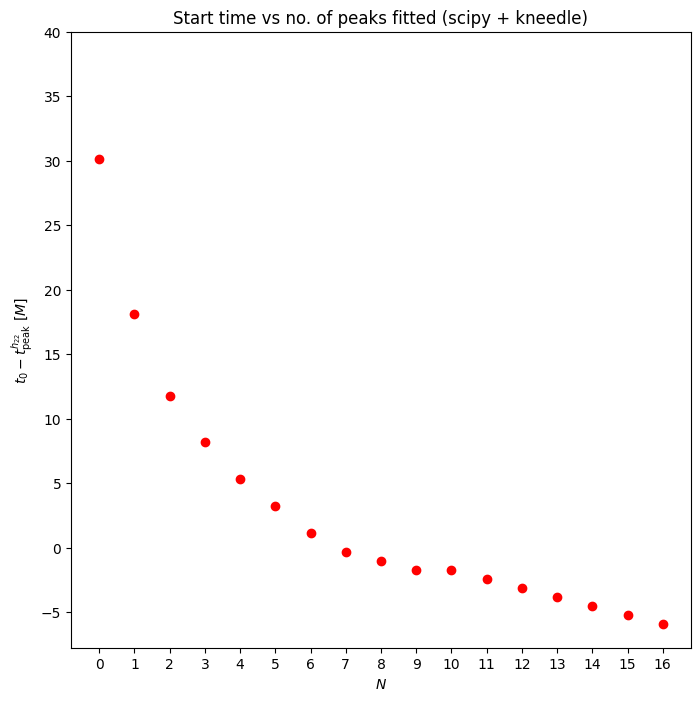

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(np.arange(N-1),np.array(ptims),color="red")

#ax.grid(which='both')
ax.set_title(r'Start time vs no. of peaks fitted (scipy + kneedle)')
ax.set_xlabel('$N$')
ax.set_ylabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
#ax.set_yscale('log')

ax.set_yticks(np.linspace(-5,40,10))
ax.set_xticks(np.arange(N-1))

plt.savefig('starttimevspeaks.png', dpi=500, bbox_inches='tight')

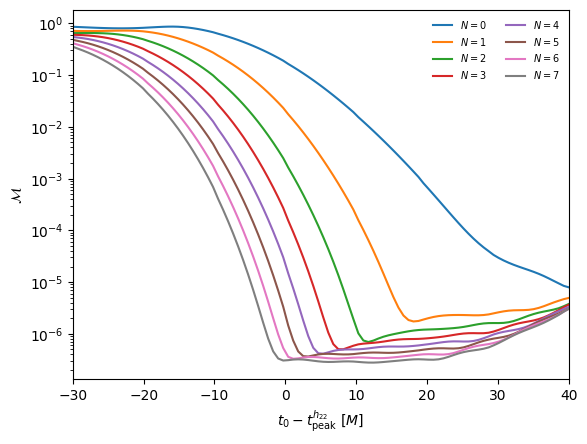

In [ ]:
# We will fit to the (2,2) spherical-harmonic mode, with the following
# combinations of modes:
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,7+2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# Create figure
fig, ax = plt.subplots(dpi=100)

for modes in mode_list:
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h[2,2],
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=t0_array
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-2]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)

In [2]:
k = 6

modes = [(2,2,n,1) for n in range(k)]
eps = qnmfits.calculate_epsilon_delta(
            sim.times,
            sim.h[2,2],
            modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=0,
            deltas=[0, 0, 0, 0, 0, 0]
        )

print(eps)

NameError: name 'qnmfits' is not defined

## Vary remnant mass and spin in the fit

We can also perform fits over a grid of remnant mass and spin values with the `qnmfits.mismatch_M_chi_grid` function. This returns a grid of mismatch values:

100%|██████████| 2500/2500 [00:03<00:00, 658.36it/s]


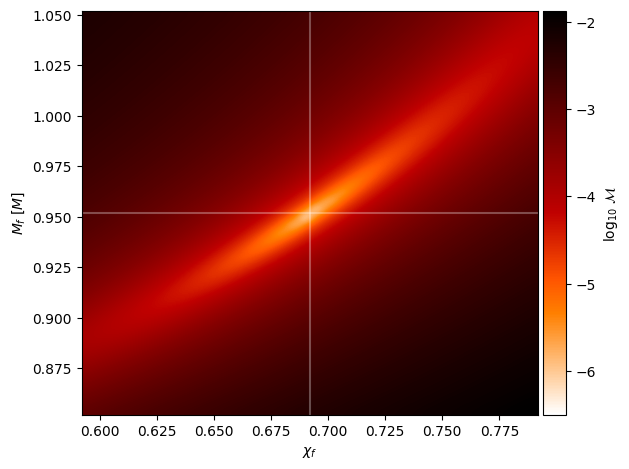

In [ ]:
# Perform a fit from the time of peak strain with seven overtones:
modes = [(2,2,n,1) for n in range(7+1)]

Mf_minmax = [sim.Mf-0.1, sim.Mf+0.1]
chif_minmax = [sim.chif_mag-0.1, sim.chif_mag+0.1]

# We provide tuples for the mass and spin to define the grid boundaries
mm_grid = qnmfits.mismatch_M_chi_grid(
    sim.times,
    sim.h[2,2],
    modes,
    Mf_minmax=Mf_minmax, 
    chif_minmax=chif_minmax,
    t0=0
)

# There is a function to plot the result as a heatmap:
qnmfits.plot_mismatch_M_chi_grid(
    mm_grid,
    Mf_minmax,
    chif_minmax,
    truth=[sim.Mf,sim.chif_mag],
    fig_kw={'dpi':100}
)

In [ ]:
# Finally, we can calculate "epsilon" (that is, the "distance" between the 
# true remnant mass and spin, and the mass and spin which minimize the 
# mismatch) by using a minimization method available in 
# scipy.optimize.minimize
epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
    sim.times,
    sim.h[2,2],
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0
)

print(f'\n\nepsilon = {epsilon}')
print(f'Mf_bestfit = {Mf_bestfit}')
print(f'chif_bestfit = {chif_bestfit}\n')



epsilon = 0.0003376298216387589
Mf_bestfit = 0.951799383218874
chif_bestfit = 0.6923290008141458



## Multimode QNM fits

For multimode fits, use the `qnmfits.multimode_ringdown_fit` function:

Mismatch = 1.280145498605556e-06


TypeError: 'float' object is not callable

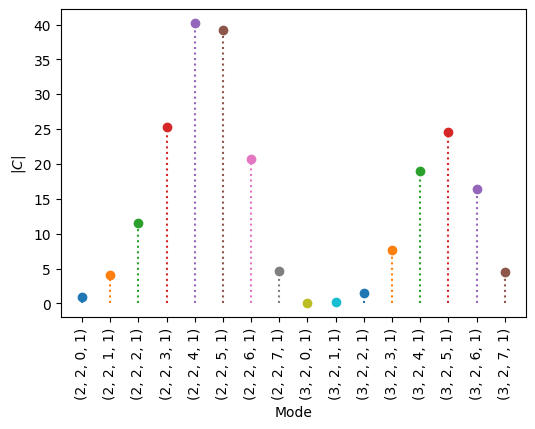

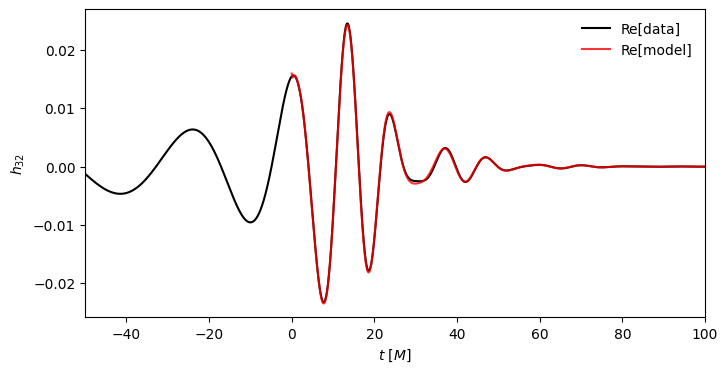

In [ ]:
# Perform a fit to the (2,2) and (3,2) spherical-harmonic modes using a 
# ringdown model with overtones of the fundamental (2,2,0) and (3,3,0) modes 
# (up to and including n=7)

modes = [(l,2,n,1) for l in range(2,3+1) for n in range(7+1)]

# We must specify the spherical modes we want to include in the fit
spherical_modes = [(2,2),(3,2)]

best_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0=0,
    spherical_modes=spherical_modes
)

print(f"Mismatch = {best_fit['mismatch']}")

qnmfits.plot_mode_amplitudes(
    best_fit['C'], best_fit['mode_labels'], log=False)

# We can specify which spherical mode we want to plot:

qnmfits.plot_ringdown(
    sim.times,
    sim.h,
    best_fit=best_fit,
    spherical_mode=(3,2)
)

peak_value = max(abs(sim.h[2,2]))

qnmfits.plot_ringdown_modes(
    best_fit,
    spherical_mode=(3,2),
    xlim=(-0.5,20), 
    ylim=(-peak_value*1.1,peak_value*1.1), 
    legend=False)

As with the `multimode_ringdown_fit` function, we specify which spherical-harmonic modes to consider with the `spherical_modes` argument:

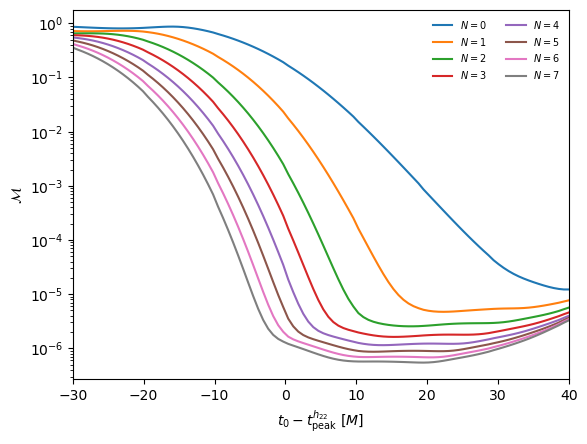

In [ ]:
mode_list = [
    [(l,2,n,1) for l in range(2,3+1) for n in range(N)] for N in range(1,7+2)
]
spherical_modes = [(2,2),(3,2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# Create figure
fig, ax = plt.subplots(dpi=100)

for modes in mode_list:
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        sim.times,
        sim.h,
        modes,
        Mf=sim.Mf,
        chif=sim.chif_mag,
        t0_array=t0_array,
        spherical_modes=spherical_modes
    )
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, label=f'$N = {modes[-1][-2]}$')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)

100%|██████████| 2500/2500 [00:05<00:00, 419.51it/s]


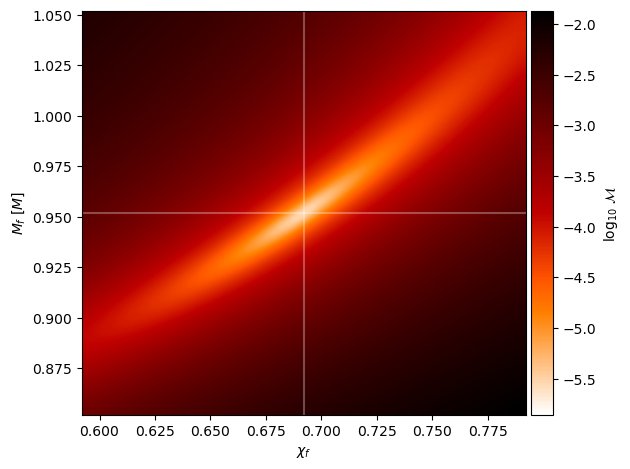

In [ ]:
modes = [(l,2,n,1) for l in range(2,3+1) for n in range(7+1)]
spherical_modes = [(2,2),(3,2)]

Mf_minmax = [sim.Mf-0.1, sim.Mf+0.1]
chif_minmax = [sim.chif_mag-0.1, sim.chif_mag+0.1]

# We provide tuples for the mass and spin to define the grid boundaries
mm_grid = qnmfits.mismatch_M_chi_grid(
    sim.times,
    sim.h,
    modes,
    Mf_minmax=Mf_minmax, 
    chif_minmax=chif_minmax,
    t0=0,
    spherical_modes=spherical_modes
)

# There is a function to plot the result as a heatmap:
qnmfits.plot_mismatch_M_chi_grid(
    mm_grid,
    Mf_minmax,
    chif_minmax,
    truth=[sim.Mf,sim.chif_mag],
    fig_kw={'dpi':100}
)

## Dynamic fits

We can pass arrays of length `times` for the `Mf` and `chif` arguments to mimic a time-dependant Kerr spectrum. For this, use the `dynamic_ringdown_fit` and `dynamic_multimode_ringdown_fit` functions. Other functions, such as `mismatch_t0_array` and `mismatch_M_chi_grid` automatically call the relevant fitting function depending on the arguments provided.

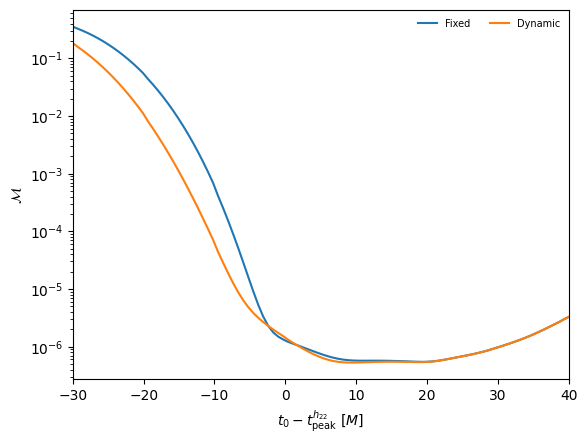

In [ ]:
# Compare the mismatch from a multimode fit using a fixed Kerr spectrum to a
# fit using a dynamic Kerr spectrum. For the dynamic fit, we provide the 
# automatically computed sim.Moft and sim.choft_mag quantities (computed from
# the fluxes).

modes = [(l,2,n,1) for l in range(2,3+1) for n in range(7+1)]
spherical_modes = [(2,2), (3,2)]

# The start times to use
t0_array = np.linspace(-30, 40, 100)

# Create mismatch lists
mm_list = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h,
    modes,
    Mf=sim.Mf,
    chif=sim.chif_mag,
    t0_array=t0_array,
    spherical_modes=spherical_modes
)

mm_list_dynamic = qnmfits.mismatch_t0_array(
    sim.times,
    sim.h,
    modes,
    Mf=sim.Moft,
    chif=sim.chioft_mag,
    t0_array=t0_array,
    spherical_modes=spherical_modes
)

# Create figure
fig, ax = plt.subplots(dpi=100)

# Add to figure
ax.semilogy(t0_array, mm_list, label='Fixed')
ax.semilogy(t0_array, mm_list_dynamic, label='Dynamic')
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('$t_0 - t^{h_{22}}_\mathrm{peak}\ [M]$')
ax.set_ylabel('$\mathcal{M}$')

_ = ax.legend(ncol=2, frameon=False, fontsize=7)